In [1]:
from collections import defaultdict
from matplotlib import pyplot as plt
from adjustText import adjust_text
import scienceplots

## Nature用設定 ##
plt.style.use(['science','nature','sans','no-latex','std-colors'])
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (2,2)
# 軸
plt.rcParams['xtick.minor.visible'] = False
plt.rcParams['xtick.major.top'] = False
plt.rcParams['xtick.minor.top'] = False
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.minor.visible'] = False
plt.rcParams['ytick.major.right'] = False
plt.rcParams['ytick.minor.right'] = False
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
# 文字
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 5
plt.rcParams['axes.labelsize'] = 5
plt.rcParams['axes.titlesize'] = 5
plt.rcParams['legend.fontsize'] = 5
# その他
plt.rcParams['axes.grid'] = False
COLOR_CYCLE = plt.rcParams['axes.prop_cycle'].by_key()['color']

import math
import numpy as np
import pandas as pd
pd.set_option("display.max_columns",50)
import pickle

from scipy import stats
from scipy.stats import spearmanr,ttest_1samp, pearsonr

import configparser
config = configparser.ConfigParser()
config.read('../config.ini', encoding='utf-8')
SAVE_DIR = config.get('settings','SAVE_DIR')
WORK_DIR = config.get('settings','WORK_DIR')
SHARE_DIR = config.get('settings','SHARE_DIR')

settings = configparser.ConfigParser()
settings.read('../settings.ini', encoding='utf-8')
MIN_YEAR = int(settings.get('experiment','MIN_YEAR'))
MAX_YEAR = int(settings.get('experiment','MAX_YEAR'))
RESOLUTION = float(settings.get('experiment','RESOLUTION'))
NMIN = int(settings.get('experiment','NMIN'))
RESOLUTION_TOPIC = float(settings.get('experiment','RESOLUTION_TOPIC'))
NMIN_TOPIC = int(settings.get('experiment','NMIN_TOPIC'))

In [2]:
papers = pd.read_pickle('/disks/qnap2/data/t-miura/2023_readership/final_paper/check1_valid_readers/papers_2016_all_validread.pickle')
for year in range(2016,2022):
    papers[f'c_history_sum_{year}'] = papers['c_history'].map(lambda l: sum(l[:year-2015]))

In [3]:
papers_hcp = papers[papers['label_hml_2021'].isin(['top'])]
papers_mcp = papers[papers['label_hml_2021'].isin(['middle'])]
papers_lcp = papers[papers['label_hml_2021'].isin(['bottom'])]
papers_slow = papers[(papers['label_hml_2018'].isin(['middle','bottom']))&(papers['label_hml_2021'].isin(['top']))]
papers_fast = papers[(papers['label_hml_2018'].isin(['top']))&(papers['label_hml_2021'].isin(['top']))]
papers_low = papers[(papers['label_hml_2018'].isin(['middle','bottom']))&(papers['label_hml_2021'].isin(['middle','bottom']))]

papers_slow_lowmatched2018_journal = papers.loc[pd.read_pickle('/disks/qnap2/data/t-miura/2023_readership/final_paper/check1_valid_readers/papers_slow_1e-06_lowmatched2018_journal.pickle').index]
papers_low_slowmatched2018_journal = papers.loc[pd.read_pickle('/disks/qnap2/data/t-miura/2023_readership/final_paper/check1_valid_readers/papers_low_1e-06_slowmatched2018_journal.pickle').index]
papers_slow_fastmatched2021_journal = papers.loc[pd.read_pickle('/disks/qnap2/data/t-miura/2023_readership/final_paper/check1_valid_readers/papers_slow_1e-06_fastmatched2021_journal.pickle').index]
papers_fast_slowmatched2021_journal = papers.loc[pd.read_pickle('/disks/qnap2/data/t-miura/2023_readership/final_paper/check1_valid_readers/papers_fast_1e-06_slowmatched2021_journal.pickle').index]

_ = pd.read_excel(
     SAVE_DIR+f'paper_detail/keywords_in_2021_{RESOLUTION}_{NMIN}_tficf_waltman_name.xlsx', 
     sheet_name='names'
 )[['partition','n_1970-2021','n_2016','nameByGPT-4'] + [f'word{i}' for i in range(5)]]
keywords = {int(k):v for k,v in _.set_index('partition')['nameByGPT-4'].to_dict().items()}
MAX_PARTITION = 47 # 論文が10000以上ある分野に絞る
# MAX_PARTITION = 65 # 全分野の場合

colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])[[0,1,2,3]]
with open(SAVE_DIR+f'paper_detail/partition_to_ASJC_in_2021_{RESOLUTION}_{NMIN}.pickle','rb') as f:
    pid_to_largefield = pickle.load(f)

target_partitions = []
for i in [3,1,0,2]:
    target_partitions.extend([k for k,v in pid_to_largefield.items() if (v == i) & (k < MAX_PARTITION+1) & (k != -1)])
target_partitions_dic = {k:i+1 for i,k in enumerate(target_partitions)}

asjc_name = {
    0: 'Health Sciences',
    1: 'Life Sciences',
    2: 'Physical Sciences',
    3: 'Social Sciences'
}

# 1. Pairwise analysis

In [4]:
def get_diff(diff_list):
    """サンプルした後の平均値と信頼区間を返す"""
    np.random.seed(42)
    N_SAMPLE = 651
    diff_list = np.random.choice(diff_list, size=N_SAMPLE)
    val_mean = np.mean(diff_list)
    val_conf = 1.96 * diff_list.std() / np.sqrt(len(diff_list))
    return val_mean, val_conf

In [5]:
years = range(2016,2022)

slow_low_diff_reader = {
    year: papers_slow_lowmatched2018_journal[f'cumulative_reader_{year}'].map(lambda x: np.log(x+1)).values - papers_low_slowmatched2018_journal[f'cumulative_reader_{year}'].map(lambda x: np.log(x+1)).values
    for year in years
}

slow_low_diff_citation = {
    year: papers_slow_lowmatched2018_journal[f'c_history_sum_{year}'].map(lambda x: np.log(x+1)).values - papers_low_slowmatched2018_journal[f'c_history_sum_{year}'].map(lambda x: np.log(x+1)).values
    for year in years
}

slow_fast_diff_reader = {
    year: papers_slow_fastmatched2021_journal[f'cumulative_reader_{year}'].map(lambda x: np.log(x+1)).values - papers_fast_slowmatched2021_journal[f'cumulative_reader_{year}'].map(lambda x: np.log(x+1)).values
    for year in years
}

slow_fast_diff_citation = {
    year: papers_slow_fastmatched2021_journal[f'c_history_sum_{year}'].map(lambda x: np.log(x+1)).values - papers_fast_slowmatched2021_journal[f'c_history_sum_{year}'].map(lambda x: np.log(x+1)).values
    for year in years
}

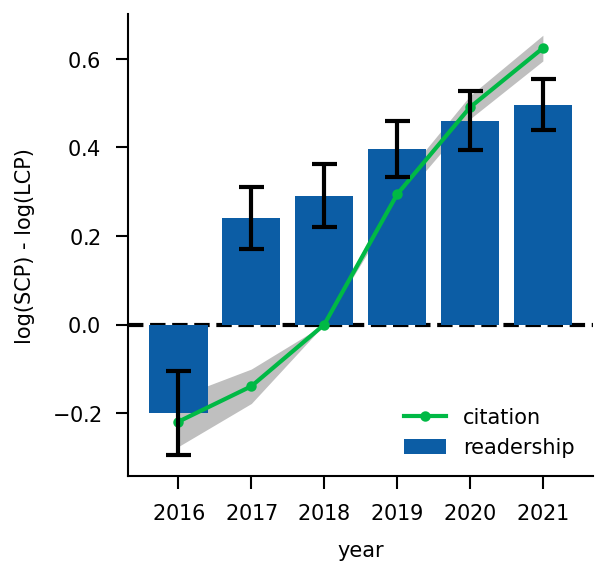

In [6]:
# Match_2018_Journal_slow_low
diff_means_reader = []
diff_confs_reader = []
for year, diff_list in slow_low_diff_reader.items():
    mean, conf = get_diff(diff_list)
    diff_means_reader.append(mean)
    diff_confs_reader.append(conf)

diff_means_citation = []
diff_confs_citation = []
for year, diff_list in slow_low_diff_citation.items():
    mean, conf = get_diff(diff_list)
    diff_means_citation.append(mean)
    diff_confs_citation.append(conf)
diff_means_citation = np.array(diff_means_citation)
diff_confs_citation = np.array(diff_confs_citation)

fig,ax = plt.subplots(figsize=(2,2))
ax.bar(years,diff_means_reader,yerr=diff_confs_reader, color=COLOR_CYCLE[0], align='center', capsize=3, ecolor='black', label='readership', zorder=5)
ax.plot(years,diff_means_citation, color=COLOR_CYCLE[1], marker='.', label='citation', zorder=5)
ax.fill_between(years,diff_means_citation-diff_confs_citation,diff_means_citation+diff_confs_citation, alpha=0.5,color='gray', linewidth=0)
ax.axhline(0, linestyle='--', color='black')
ax.set_xlabel('year')
ax.set_ylabel('log(SCP) - log(LCP)')
ax.legend(loc='lower right')
# ax.grid(alpha=0.2, zorder=-10)
plt.savefig('./sb_lcp_cohen.pdf')
plt.show()

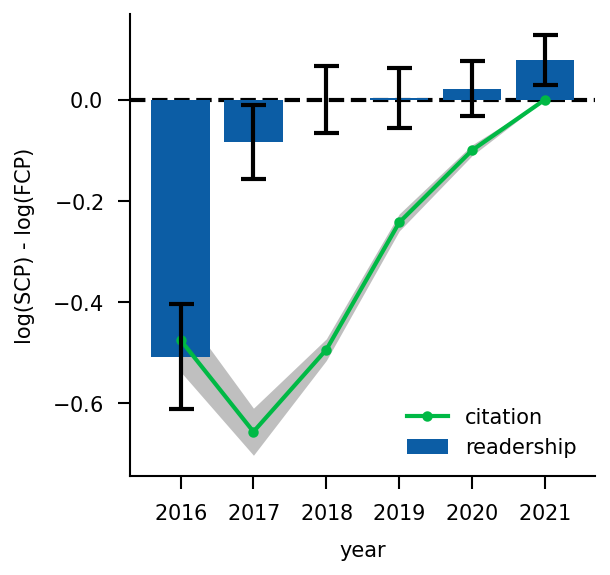

In [7]:
# Match_2021_Journal_fast_slow
diff_means_reader = []
diff_confs_reader = []
for year, diff_list in slow_fast_diff_reader.items():
    mean, conf = get_diff(diff_list)
    diff_means_reader.append(mean)
    diff_confs_reader.append(conf)

diff_means_citation = []
diff_confs_citation = []
for year, diff_list in slow_fast_diff_citation.items():
    mean, conf = get_diff(diff_list)
    diff_means_citation.append(mean)
    diff_confs_citation.append(conf)
diff_means_citation = np.array(diff_means_citation)
diff_confs_citation = np.array(diff_confs_citation)

fig,ax = plt.subplots(figsize=(2,2))
ax.bar(years,diff_means_reader,yerr=diff_confs_reader, color=COLOR_CYCLE[0], align='center', capsize=3, ecolor='black', label='readership', zorder=5)
ax.plot(years,diff_means_citation, color=COLOR_CYCLE[1], marker='.', label='citation', zorder=5)
ax.fill_between(years,diff_means_citation-diff_confs_citation,diff_means_citation+diff_confs_citation, alpha=0.5,color='gray', linewidth=0)
ax.axhline(0, linestyle='--', color='black')
ax.set_xlabel('year')
ax.set_ylabel('log(SCP) - log(FCP)')
ax.legend(loc='lower right')
# ax.grid(alpha=0.2, zorder=-10)
plt.savefig('./sb_fcp_cohen.pdf')
plt.show()

In [8]:
print('readership')
for year in range(2016,2022):
    print(f'slow - low({year}): ', slow_low_diff_reader[year].mean(), np.exp(slow_low_diff_reader[year].mean()))
    print(f'slow - fast({year}):', slow_fast_diff_reader[year].mean(), np.exp(slow_fast_diff_reader[year].mean()))
print()
print('citation')
for year in range(2016,2022):
    print(f'slow - low({year}): ', slow_low_diff_citation[year].mean(), np.exp(slow_low_diff_citation[year].mean()))
    print(f'slow - fast({year}):', slow_fast_diff_citation[year].mean(), np.exp(slow_fast_diff_citation[year].mean()))

readership
slow - low(2016):  -0.26073599573740663 0.7704843039072307
slow - fast(2016): -0.5089609313937692 0.6011198591952962
slow - low(2017):  0.16589310414104855 1.1804469100923138
slow - fast(2017): -0.14802981181788277 0.862405404685947
slow - low(2018):  0.27549791432417653 1.317186357572215
slow - fast(2018): -0.06358127780278966 0.9383978452860064
slow - low(2019):  0.3878096173538813 1.4737491813091677
slow - fast(2019): -0.021751464722368132 0.9784833924749665
slow - low(2020):  0.4247591715045242 1.5292220950572275
slow - fast(2020): 0.020763400418693366 1.0209804595091154
slow - low(2021):  0.46928578330037807 1.5988518586310445
slow - fast(2021): 0.05605609265873 1.0576570088663952

citation
slow - low(2016):  -0.20800256415430823 0.8122049540904367
slow - fast(2016): -0.49500692822792464 0.6095666840647571
slow - low(2017):  -0.15293463689148165 0.8581858136706725
slow - fast(2017): -0.6104675895480518 0.5430968632770516
slow - low(2018):  0.0 1.0
slow - fast(2018): -0.

In [9]:
print('readership')
for year in range(2016,2022):
    print(f'slow - low({year}): ', slow_low_diff_reader[year].mean(), np.exp(slow_low_diff_reader[year].mean()))
    print(f'slow - fast({year}):', slow_fast_diff_reader[year].mean(), np.exp(slow_fast_diff_reader[year].mean()))
print()
print('citation')
for year in range(2016,2022):
    print(f'slow - low({year}): ', slow_low_diff_citation[year].mean(), np.exp(slow_low_diff_citation[year].mean()))
    print(f'slow - fast({year}):', slow_fast_diff_citation[year].mean(), np.exp(slow_fast_diff_citation[year].mean()))

readership
slow - low(2016):  -0.2583865876143061 0.772296614084057
slow - fast(2016): -0.5067559364976266 0.6024467878145808
slow - low(2017):  0.1757604403286958 1.1921524327948725
slow - fast(2017): -0.1452045046390805 0.864845410126204
slow - low(2018):  0.2922703795540237 1.3394651326680387
slow - fast(2018): -0.05961001523147127 0.9421318790327963
slow - low(2019):  0.3985354317896278 1.4896414177850468
slow - fast(2019): -0.016814055366498496 0.9833265119243784
slow - low(2020):  0.43122827592827384 1.539146860035747
slow - fast(2020): 0.022679543649565485 1.0229386798216038
slow - low(2021):  0.4766686236227097 1.6106996078078268
slow - fast(2021): 0.05789231415580138 1.0596008855504992

citation
slow - low(2016):  -0.20678146528103328 0.8131973424235716
slow - fast(2016): -0.49431327418486365 0.6099896591419003
slow - low(2017):  -0.15059457622394234 0.8601963720354929
slow - fast(2017): -0.6126974638303246 0.5418871747767338
slow - low(2018):  0.0 1.0
slow - fast(2018): -0.50

# 2. Field analysis

In [9]:
def calc_conf(arr):
    '''
    1次元配列から、平均値・正規分布を仮定した標準誤差、95%信頼区間にする場合は1.96*標準誤差にすること
    '''
    arr_mean = np.mean(arr)
    arr_err = (np.std(arr, ddof=1) / np.sqrt(len(arr))) # = arr.sem()
    return arr_mean, arr_err*1.96

In [10]:
y, y_err = [],[]

for partition in target_partitions:
    readers_slow_matched = papers_slow_lowmatched2018_journal.query(f'`partition_1e-06`=={partition}')['cumulative_reader_2018'].map(lambda x: np.log(x+1)).values
    readers_low_matched = papers_low_slowmatched2018_journal.query(f'`partition_1e-06`=={partition}')['cumulative_reader_2018'].map(lambda x: np.log(x+1)).values
    print(partition, len(readers_slow_matched)) #各マッチ数
    mean, err = calc_conf(readers_slow_matched - readers_low_matched)
    y.append(mean) 
    y_err.append(err)

3.0 3076
32.0 532
33.0 341
46.0 126
0.0 4349
4.0 2217
5.0 1977
16.0 729
1.0 3116
8.0 724
10.0 1051
20.0 438
21.0 378
28.0 283
29.0 398
34.0 334
35.0 191
37.0 209
39.0 152
40.0 257
41.0 170
42.0 176
43.0 176
2.0 2005
6.0 1627
7.0 1489
9.0 1069
11.0 1028
12.0 600
13.0 788
14.0 741
15.0 931
17.0 350
18.0 694
19.0 601
22.0 621
23.0 677
24.0 477
25.0 477
26.0 330
27.0 351
30.0 284
31.0 256
36.0 242
38.0 249
44.0 251
45.0 137
47.0 156


全体平均 0.2775652192816415


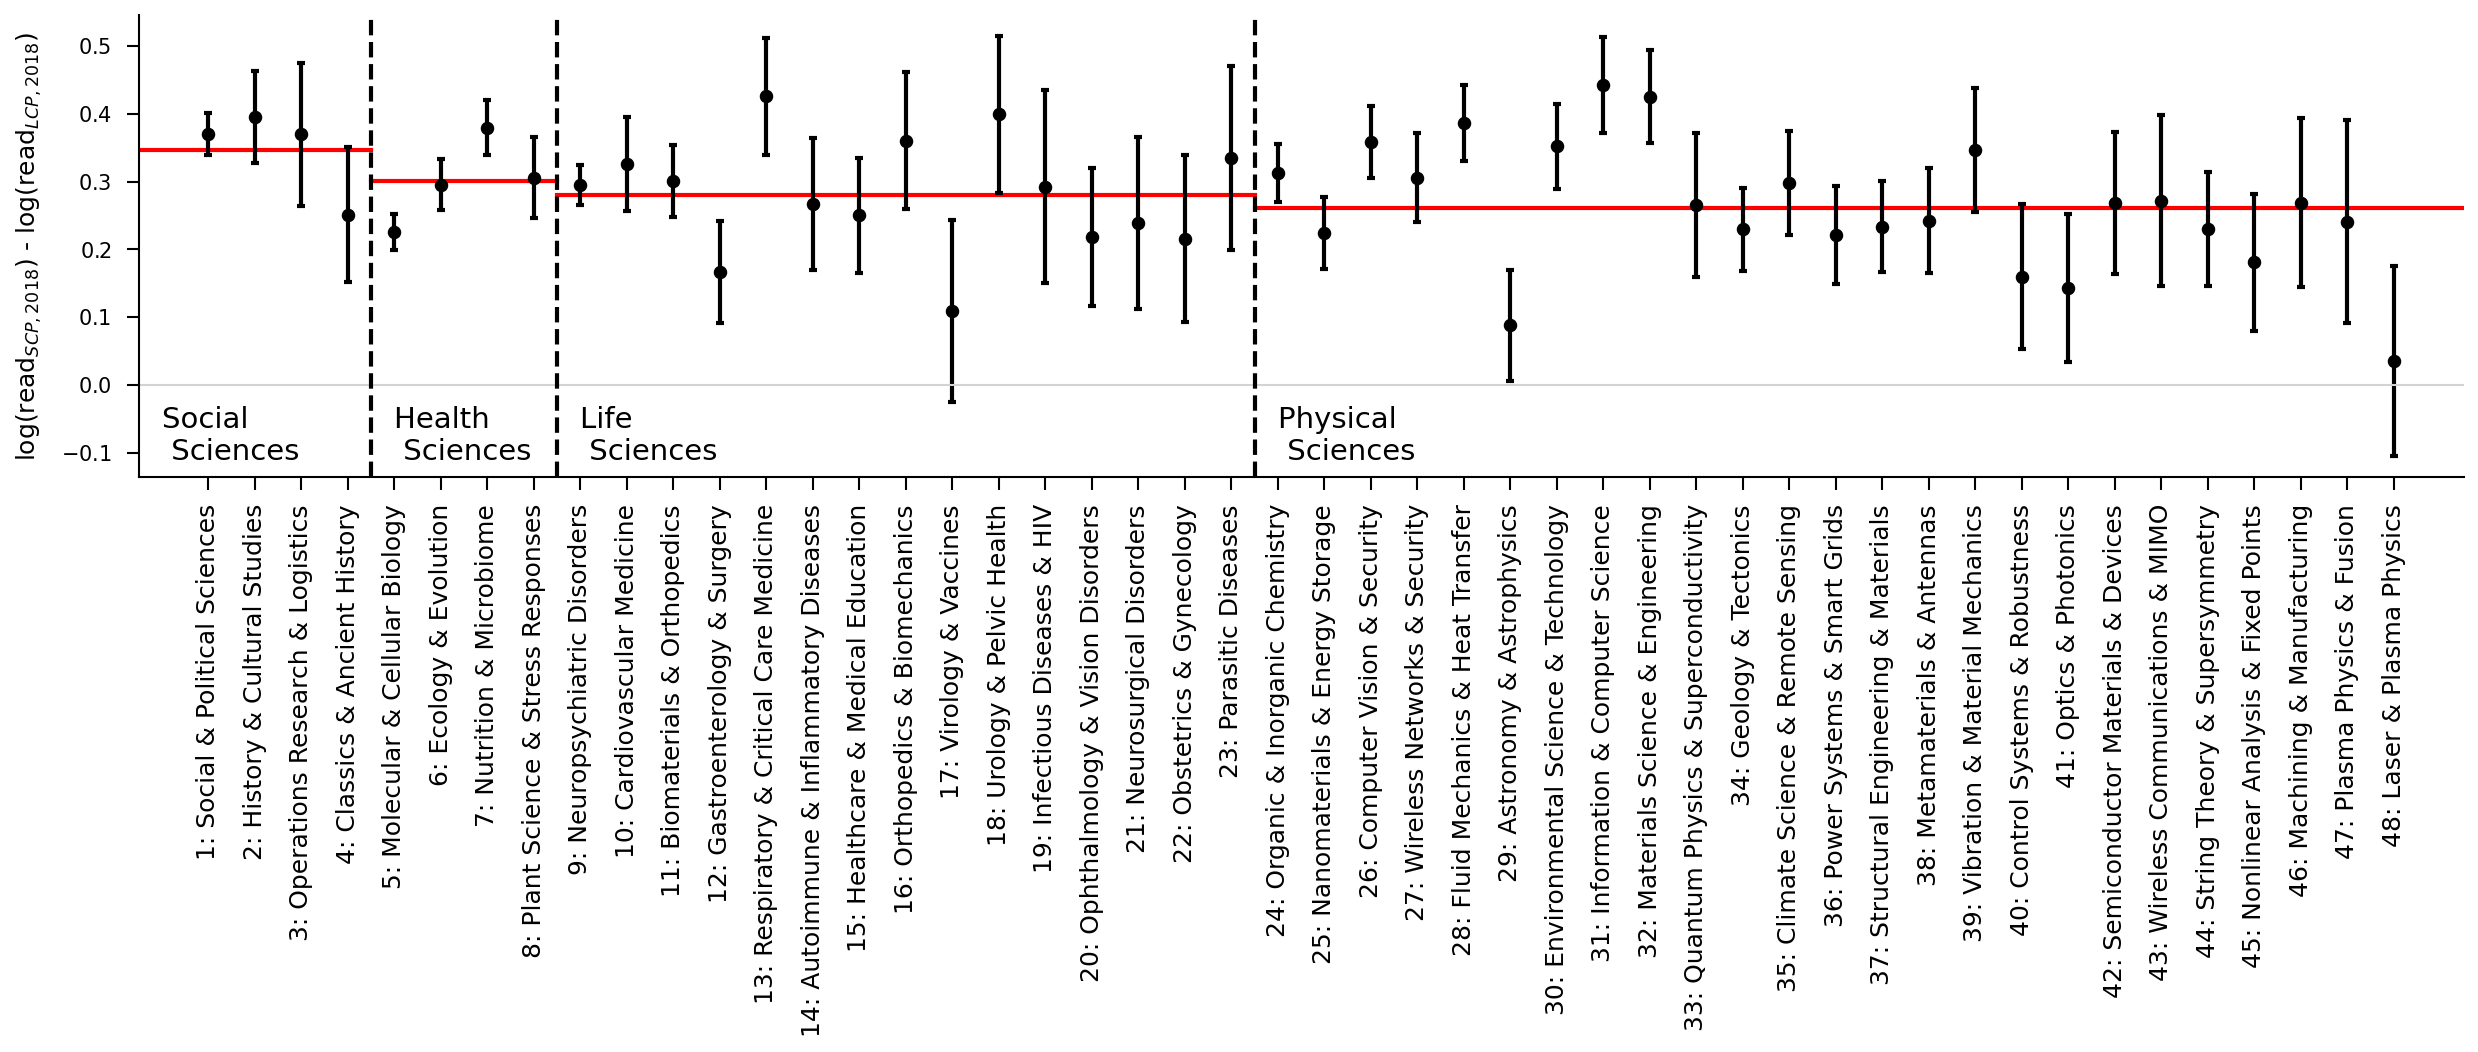

In [15]:
fig,ax = plt.subplots(figsize=(10,2))

x = range(MAX_PARTITION+1)
labels = [f'{j+1}: ' + keywords[i] for j,i in enumerate(target_partitions)]

print('全体平均', np.mean(y))
ax.scatter(x,y, s=5, color='black')
ax.errorbar(x, y, yerr=y_err, capsize=1, linestyle='None', color='black')

ax.axhline(0,c='lightgray',linestyle='-',linewidth=0.5)
ax.axhline(np.mean(y[:4]), xmin=0, xmax=0.1, linestyle='-', linewidth=1, color='red', zorder=-20) 
ax.axhline(np.mean(y[4:8]), xmin=0.1, xmax=0.18, linestyle='-', linewidth=1, color='red', zorder=-20) 
ax.axhline(np.mean(y[8:23]), xmin=0.18, xmax=0.48, linestyle='-', linewidth=1, color='red', zorder=-20) 
ax.axhline(np.mean(y[23:]), xmin=0.48, xmax=1, linestyle='-', linewidth=1, color='red', zorder=-20) 

ax.axvline(3.5, linestyle='--', linewidth=1, color='black') 
ax.axvline(7.5, linestyle='--', linewidth=1, color='black') 
ax.axvline(22.5, linestyle='--', linewidth=1, color='black') 

ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=90, fontsize=6)

ax.set_ylabel('log(read$_{SCP,2018}$) - log(read$_{LCP,2018}$)', fontsize=6)
ax.set_xlim(-1.5,48.5)

plt.text(-1,-0.11,'Social \n Sciences')
plt.text(4,-0.11,'Health \n Sciences')
plt.text(8,-0.11,'Life \n Sciences')
plt.text(23,-0.11,'Physical \n Sciences')

# ax.grid(axis='y', alpha=0.8)
# ax.legend(loc='upper right', fontsize=10)

plt.savefig('./scp_lcp_field.eps')
plt.show()

全体平均 0.24902566962808378


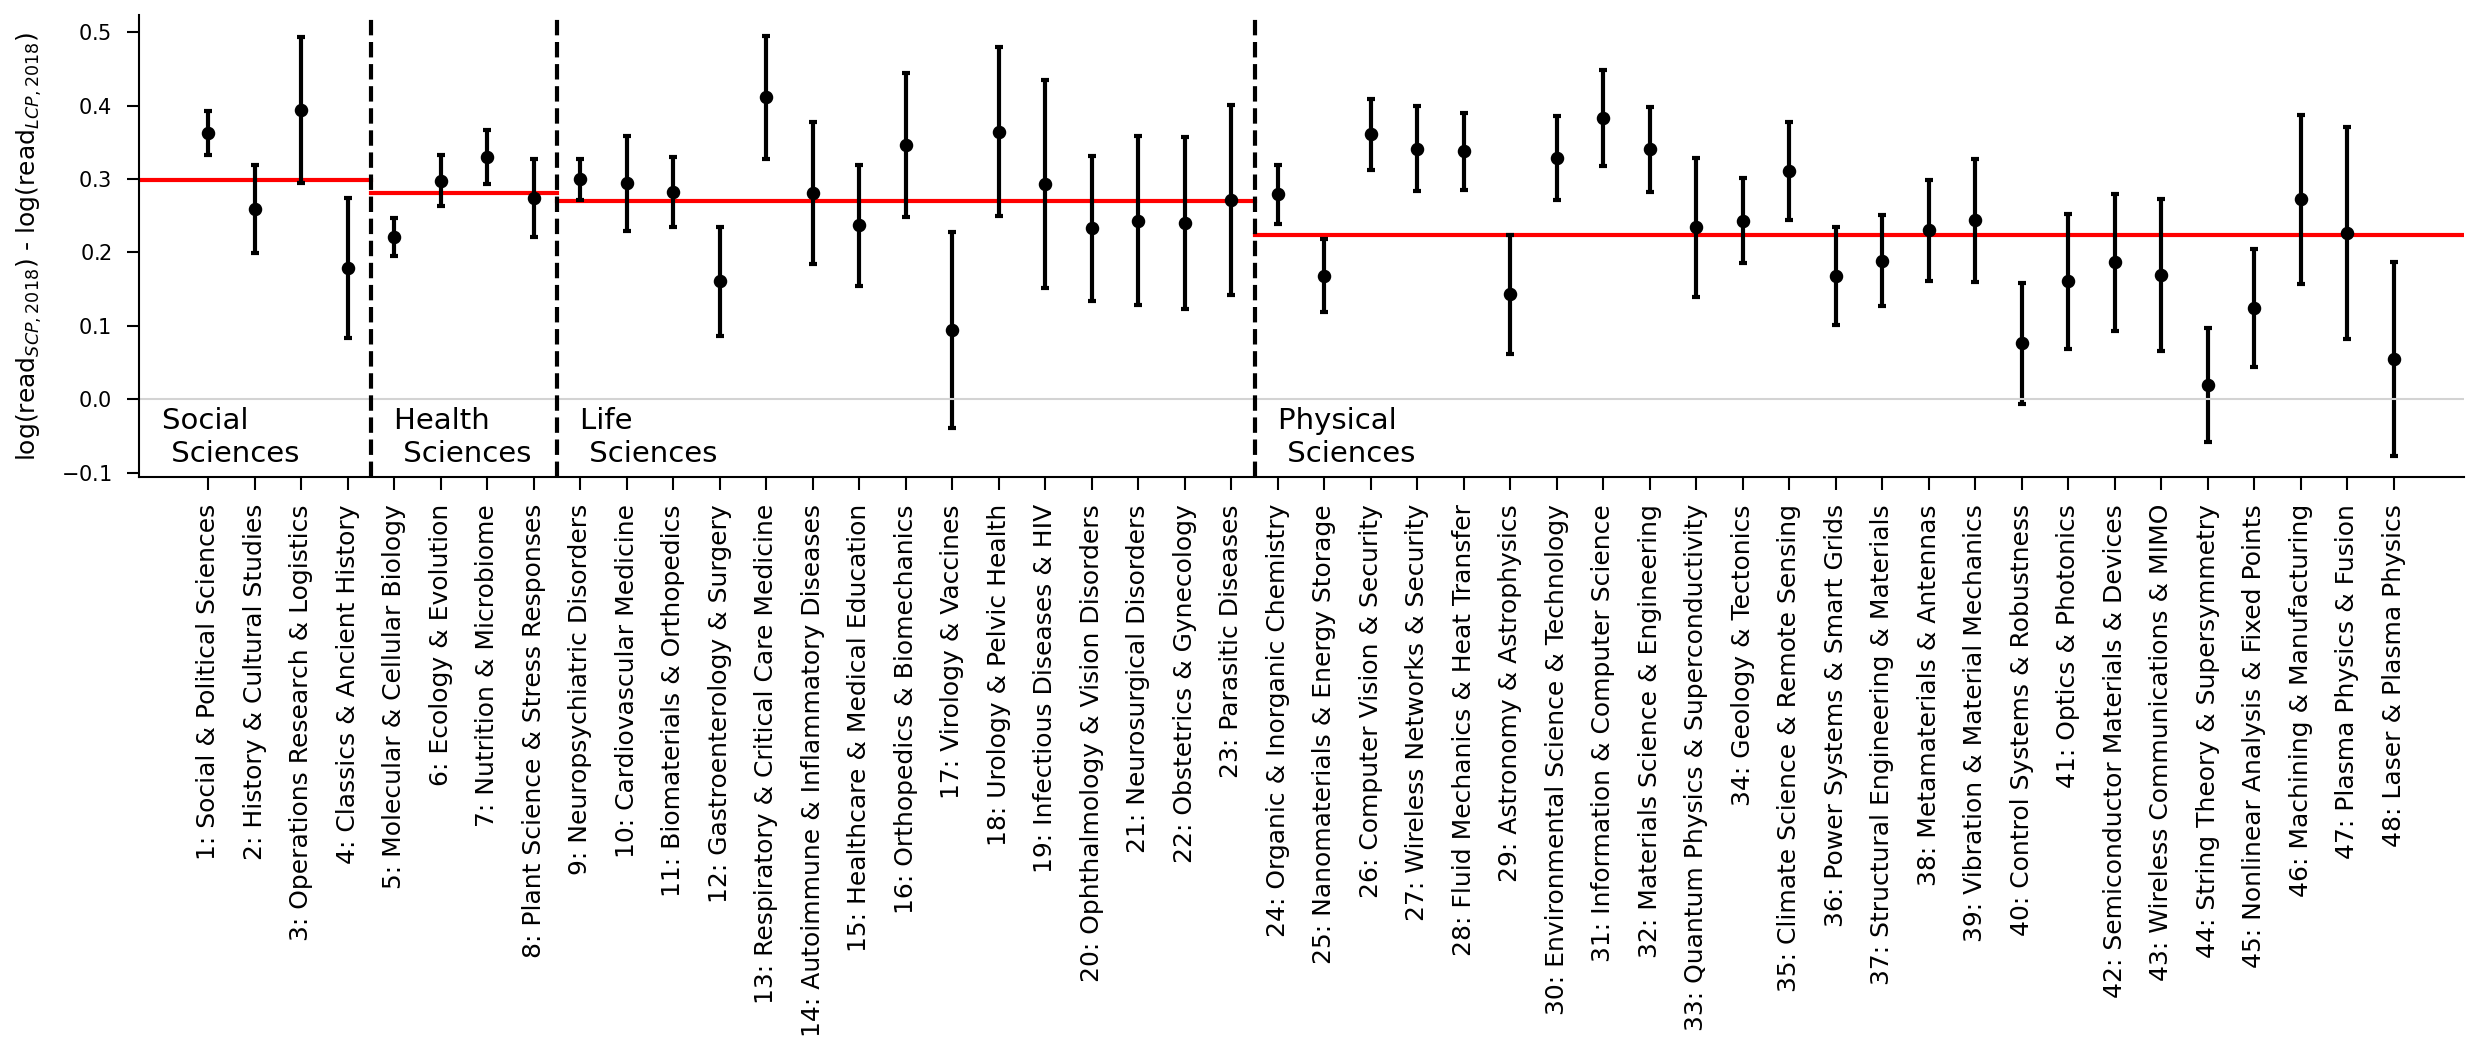

In [13]:
fig,ax = plt.subplots(figsize=(10,2))

x = range(MAX_PARTITION+1)
labels = [f'{j+1}: ' + keywords[i] for j,i in enumerate(target_partitions)]

print('全体平均', np.mean(y))
ax.scatter(x,y, s=5, color='black')
ax.errorbar(x, y, yerr=y_err, capsize=1, linestyle='None', color='black')

ax.axhline(0,c='lightgray',linestyle='-',linewidth=0.5)
ax.axhline(np.mean(y[:4]), xmin=0, xmax=0.1, linestyle='-', linewidth=1, color='red', zorder=-20) 
ax.axhline(np.mean(y[4:8]), xmin=0.1, xmax=0.18, linestyle='-', linewidth=1, color='red', zorder=-20) 
ax.axhline(np.mean(y[8:23]), xmin=0.18, xmax=0.48, linestyle='-', linewidth=1, color='red', zorder=-20) 
ax.axhline(np.mean(y[23:]), xmin=0.48, xmax=1, linestyle='-', linewidth=1, color='red', zorder=-20) 

ax.axvline(3.5, linestyle='--', linewidth=1, color='black') 
ax.axvline(7.5, linestyle='--', linewidth=1, color='black') 
ax.axvline(22.5, linestyle='--', linewidth=1, color='black') 

ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=90, fontsize=6)

ax.set_ylabel('log(read$_{SCP,2018}$) - log(read$_{LCP,2018}$)', fontsize=6)
ax.set_xlim(-1.5,48.5)

plt.text(-1,-0.085,'Social \n Sciences')
plt.text(4,-0.085,'Health \n Sciences')
plt.text(8,-0.085,'Life \n Sciences')
plt.text(23,-0.085,'Physical \n Sciences')

# ax.grid(axis='y', alpha=0.8)
# ax.legend(loc='upper right', fontsize=10)

plt.savefig('./scp_lcp_field.eps')
plt.show()

## 2.2 Corr

r,p= PearsonRResult(statistic=0.15983194074616555, pvalue=0.2886719473529927)


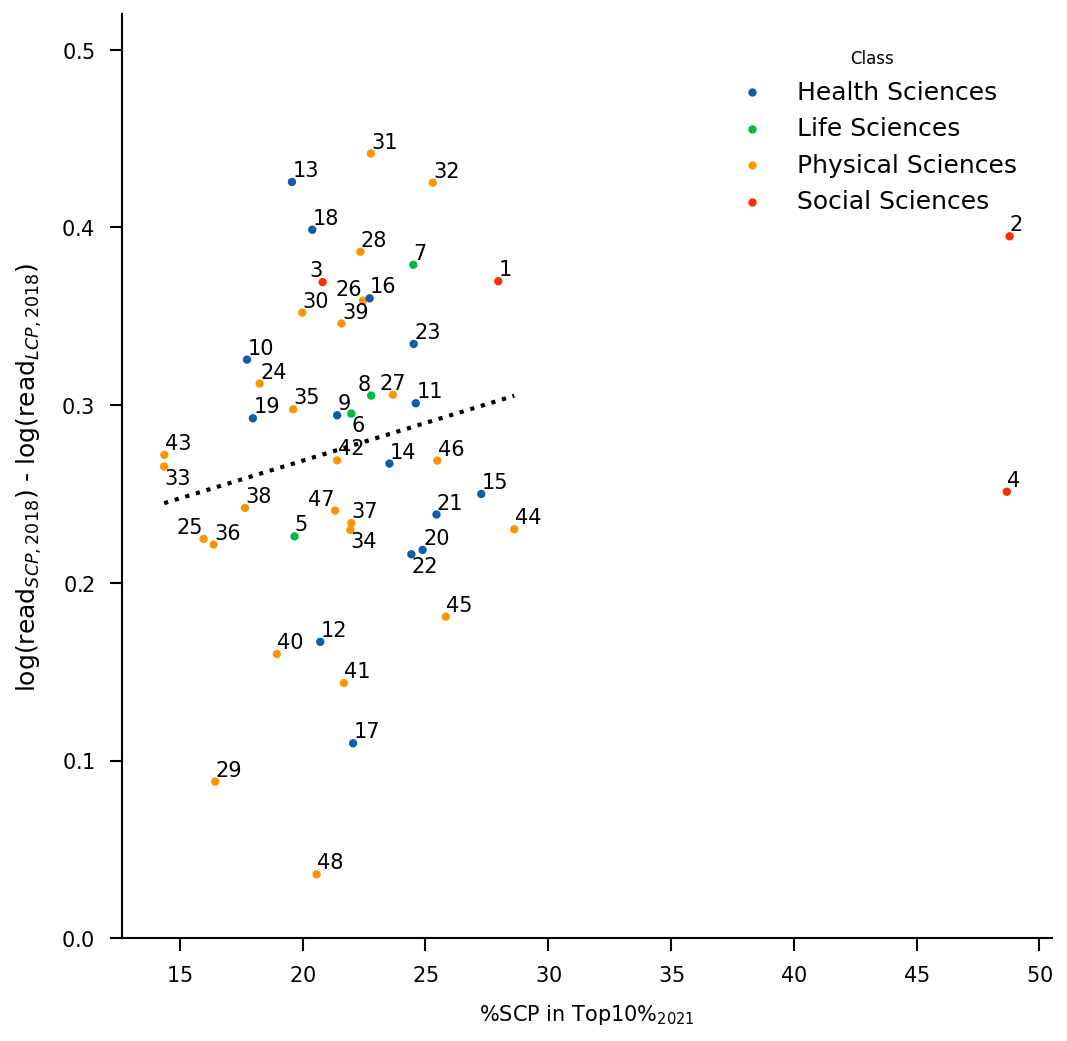

In [58]:
x,y,c = [],[],[]

for partition in range(MAX_PARTITION+1):
    c.append(COLOR_CYCLE[pid_to_largefield[partition]]) #ノードの色
    
    df_slow = papers_slow.query(f'`partition_1e-06` == {partition}')
    df_fast = papers_fast.query(f'`partition_1e-06` == {partition}')
    
    x.append(len(df_slow)*100/(len(df_slow)+len(df_fast))) # マッチしたものだけでなく全体で、2021年のtopに占める、2018年のnot topの割合

    readers_slow_matched = papers_slow_lowmatched2018_journal.query(f'`partition_1e-06`=={partition}')['cumulative_reader_2018'].map(lambda x: np.log(x+1)).values
    readers_low_matched = papers_low_slowmatched2018_journal.query(f'`partition_1e-06`=={partition}')['cumulative_reader_2018'].map(lambda x: np.log(x+1)).values
    y.append((readers_slow_matched - readers_low_matched).mean()) #マッチしたものについて、slowをよく読む割合。つまり、今は低くても後々伸びる論文をよく読む強さ
    # journal matchに変更したこと、logとって平均に変更したこと

fig,ax = plt.subplots(figsize=(4,4))
ax.scatter(x,y,s=1,c=c)
ax.set_xlabel('%SCP in Top10%$_{2021}$')
ax.set_ylabel('log(read$_{SCP,2018}$) - log(read$_{LCP,2018}$)',fontsize=6)

texts = [ax.text(xx, yy, target_partitions_dic[partition], ha='center', va='center',fontsize=5) for xx,yy,partition in zip(x,y,range(MAX_PARTITION+1))]
adjust_text(texts,force_text=(0.1,0.3),arrowprops=dict(arrowstyle='-', color='gray',linewidth=0.1))

# 2と4を除いた相関係数, 近似直線
x_wo24 = [xx for xx,partition in zip(x,range(MAX_PARTITION+1)) if target_partitions_dic[partition] not in [2,4]]
y_wo24 = [yy for yy,partition in zip(y,range(MAX_PARTITION+1)) if target_partitions_dic[partition] not in [2,4]]
x_fit = [min(x_wo24),max(x_wo24)]
print('r,p=',pearsonr(x_wo24,y_wo24))
coef = np.polyfit(x_wo24,y_wo24,1)
y_fit = np.poly1d(coef)(x_fit)
ax.plot(x_fit,y_fit,linestyle=':',color='black',linewidth=1)

#legendとformat
ax.set_ylim(0,0.52)
for i in range(4):
    ax.scatter([],[],s=1,c=COLOR_CYCLE[i],label=asjc_name[i])
ax.legend(title='Class', title_fontsize=4, frameon=False, fontsize=6, bbox_to_anchor=(1,1), loc='upper right', borderaxespad=1)

plt.savefig('./scp_lcp_field_corr.eps')
plt.show()

r,p= PearsonRResult(statistic=0.15983194074616555, pvalue=0.2886719473529927)


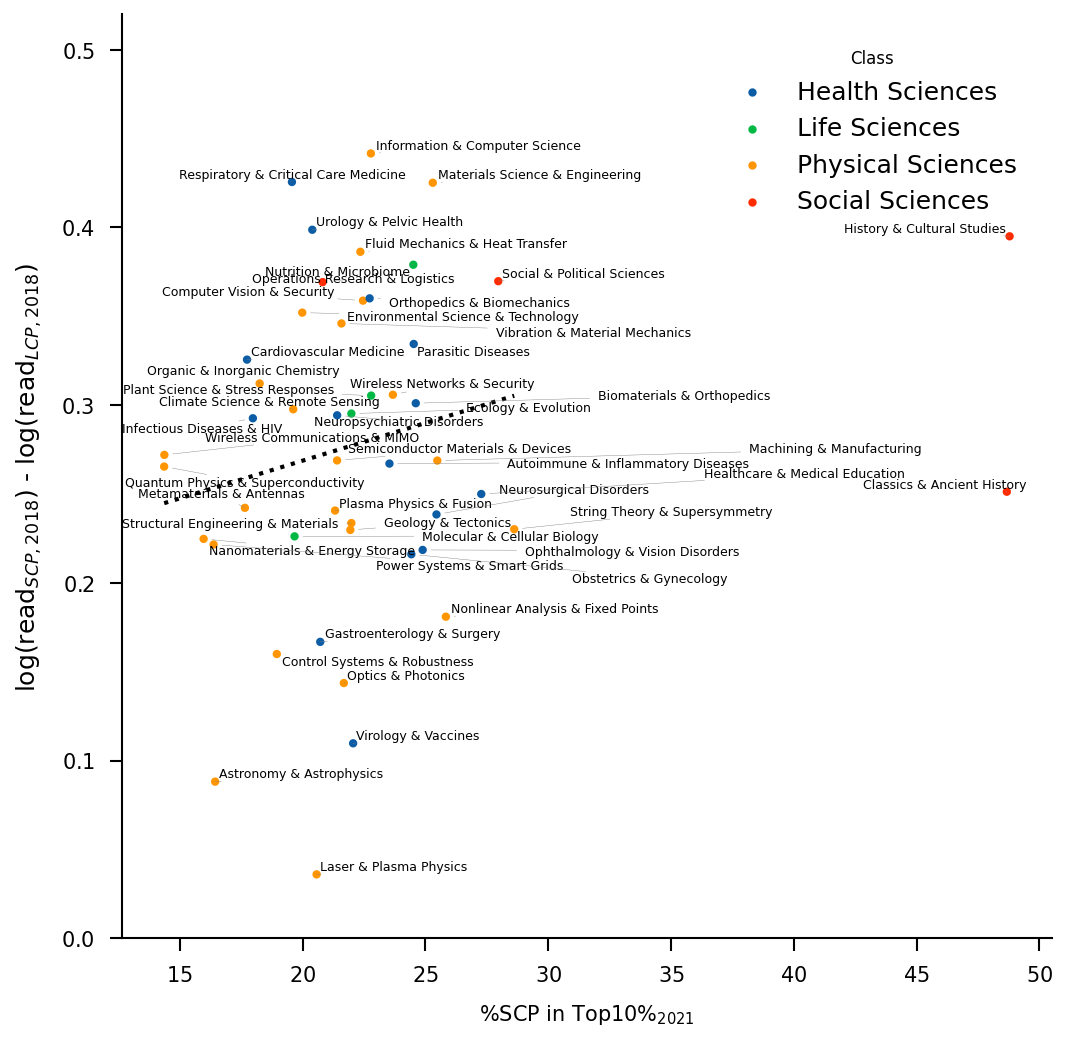

In [63]:
x,y,c = [],[],[]

for partition in range(MAX_PARTITION+1):
    c.append(COLOR_CYCLE[pid_to_largefield[partition]]) #ノードの色
    
    df_slow = papers_slow.query(f'`partition_1e-06` == {partition}')
    df_fast = papers_fast.query(f'`partition_1e-06` == {partition}')
    
    x.append(len(df_slow)*100/(len(df_slow)+len(df_fast))) # マッチしたものだけでなく全体で、2021年のtopに占める、2018年のnot topの割合

    readers_slow_matched = papers_slow_lowmatched2018_journal.query(f'`partition_1e-06`=={partition}')['cumulative_reader_2018'].map(lambda x: np.log(x+1)).values
    readers_low_matched = papers_low_slowmatched2018_journal.query(f'`partition_1e-06`=={partition}')['cumulative_reader_2018'].map(lambda x: np.log(x+1)).values
    y.append((readers_slow_matched - readers_low_matched).mean()) #マッチしたものについて、slowをよく読む割合。つまり、今は低くても後々伸びる論文をよく読む強さ
    # journal matchに変更したこと、logとって平均に変更したこと

fig,ax = plt.subplots(figsize=(4,4))
ax.scatter(x,y,s=1,c=c)
ax.set_xlabel('%SCP in Top10%$_{2021}$')
ax.set_ylabel('log(read$_{SCP,2018}$) - log(read$_{LCP,2018}$)',fontsize=6)

texts = [ax.text(xx, yy, keywords[partition], ha='center', va='center',fontsize=3) for xx,yy,partition in zip(x,y,range(MAX_PARTITION+1))]
adjust_text(texts,force_text=(0.1,0.3),arrowprops=dict(arrowstyle='-', color='gray',linewidth=0.1))

# 2と4を除いた相関係数, 近似直線
x_wo24 = [xx for xx,partition in zip(x,range(MAX_PARTITION+1)) if target_partitions_dic[partition] not in [2,4]]
y_wo24 = [yy for yy,partition in zip(y,range(MAX_PARTITION+1)) if target_partitions_dic[partition] not in [2,4]]
x_fit = [min(x_wo24),max(x_wo24)]
print('r,p=',pearsonr(x_wo24,y_wo24))
coef = np.polyfit(x_wo24,y_wo24,1)
y_fit = np.poly1d(coef)(x_fit)
ax.plot(x_fit,y_fit,linestyle=':',color='black',linewidth=1)

#legendとformat
ax.set_ylim(0,0.52)
for i in range(4):
    ax.scatter([],[],s=1,c=COLOR_CYCLE[i],label=asjc_name[i])
ax.legend(title='Class', title_fontsize=4, frameon=False, fontsize=6, bbox_to_anchor=(1,1), loc='upper right', borderaxespad=1)

plt.savefig('./scp_lcp_field_corr.eps')
plt.show()

## 2.3 doctype

In [265]:
y, y_err = [],[]

papers_havedoctypes = pd.merge(
    papers_slow_lowmatched2018_journal.assign(id=range(len(papers_slow_lowmatched2018_journal))), 
    papers_low_slowmatched2018_journal.assign(id=range(len(papers_low_slowmatched2018_journal))), 
    on='id',
    suffixes=('_slow','_low'),
).dropna(subset=['doctype_slow','doctype_low']).query('doctype_slow == doctype_low')
for doctype in ['ar','cp','re']:
    readers_slow_matched = papers_havedoctypes.query(f'doctype_slow=="{doctype}"')['cumulative_reader_2018_slow'].map(lambda x: np.log(x+1)).values
    readers_low_matched = papers_havedoctypes.query(f'doctype_low=="{doctype}"')['cumulative_reader_2018_low'].map(lambda x: np.log(x+1)).values
    print(doctype, len(readers_slow_matched))
    mean, err = calc_conf(readers_slow_matched - readers_low_matched)
    y.append(mean) 
    y_err.append(err)

ar 32194
cp 2151
re 1308


In [88]:
papers_havedoctypes.shape

(35677, 79)

In [96]:
y, np.exp(y)

([0.2714852241423895, 0.4704661388086695, 0.21194399011598786],
 array([1.31191149, 1.60074019, 1.23607865]))

全体平均 0.31796511768901564


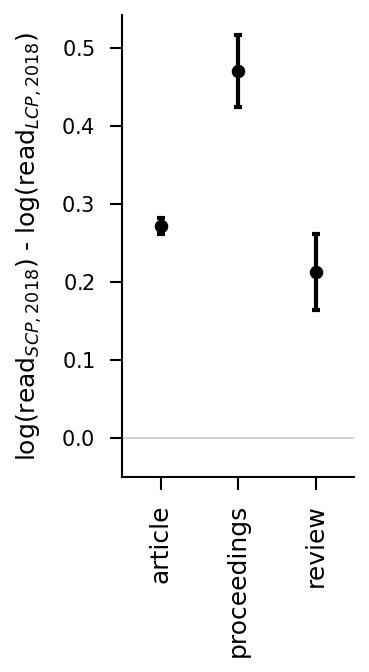

In [93]:
fig,ax = plt.subplots(figsize=(1,2))

x = range(3)
labels = ['article', 'proceedings', 'review']

print('全体平均', np.mean(y))
ax.scatter(x,y, s=5, color='black')
ax.errorbar(x, y, yerr=y_err, capsize=1, linestyle='None', color='black')

ax.axhline(0,c='lightgray',linestyle='-',linewidth=0.5)

ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=90, fontsize=6)

ax.set_ylabel('log(read$_{SCP,2018}$) - log(read$_{LCP,2018}$)', fontsize=6)

ax.set_xlim(-0.5,2.5)
ax.set_ylim(-0.05, ax.get_ylim()[1])

# ax.grid(axis='y', alpha=0.8)
# ax.legend(loc='upper right', fontsize=10)

plt.savefig('../doc/figs_update_11/scp_lcp_doctype.eps')
plt.show()

## 2.4 topic

In [241]:
papers_slow_lowmatched2018_journal_topic = papers.loc[pd.read_pickle('/disks/qnap2/data/t-miura/2023_readership/final_paper/papers_slow_1e-06_lowmatched2018_journal_topic.pickle').index]
papers_low_slowmatched2018_journal_topic = papers.loc[pd.read_pickle('/disks/qnap2/data/t-miura/2023_readership/final_paper/papers_low_1e-06_slowmatched2018_journal_topic.pickle').index]
papers_slow_fastmatched2021_journal_topic = papers.loc[pd.read_pickle('/disks/qnap2/data/t-miura/2023_readership/final_paper/papers_slow_1e-06_fastmatched2021_journal_topic.pickle').index]
papers_fast_slowmatched2021_journal_topic = papers.loc[pd.read_pickle('/disks/qnap2/data/t-miura/2023_readership/final_paper/papers_fast_1e-06_slowmatched2021_journal_topic.pickle').index]

In [244]:
print(papers_slow_lowmatched2018_journal_topic.shape)
print(papers_slow_fastmatched2021_journal_topic.shape)

(11752, 39)
(2785, 39)


In [255]:
y, y_err = [],[]

for partition in papers_slow_lowmatched2018_journal_topic['partition_0.0005'].unique():
    readers_slow_matched = papers_slow_lowmatched2018_journal_topic.query(f'`partition_0.0005`=={partition}')['cumulative_reader_2018'].map(lambda x: np.log(x+1)).values
    readers_low_matched = papers_low_slowmatched2018_journal_topic.query(f'`partition_0.0005`=={partition}')['cumulative_reader_2018'].map(lambda x: np.log(x+1)).values
    if len(readers_slow_matched) > 5:
        mean, err = calc_conf(readers_slow_matched - readers_low_matched)
        y.append(mean) 
        y_err.append(err)

In [256]:
print(len(y))

501


In [257]:
print('全体平均', np.mean(y))

全体平均 0.2229504732855156


全体平均 0.2229504732855156
114


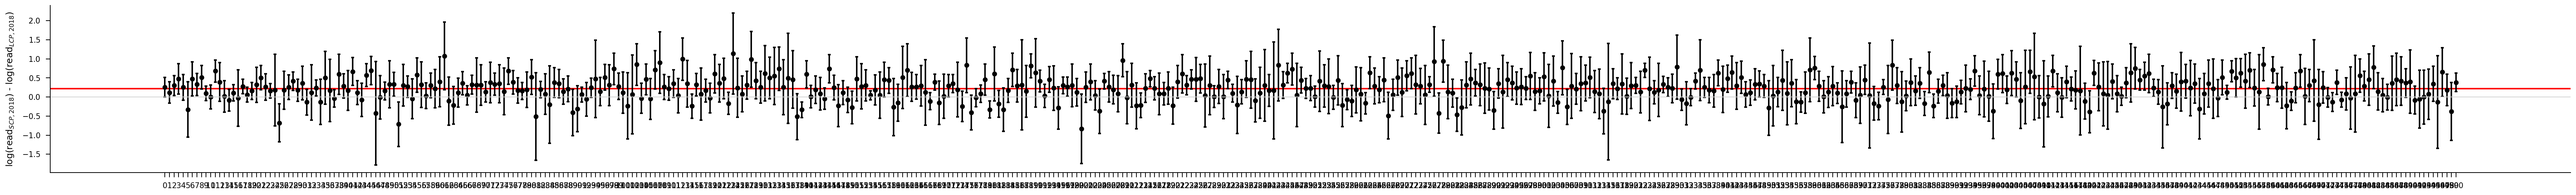

In [264]:
fig,ax = plt.subplots(figsize=(30,2))

x = range(len(y))

print('全体平均', np.mean(y))
ax.scatter(x,y, s=5, color='black')
print(len([1 for diff in (np.array(y) - np.array(y_err)) if diff > 0]))
ax.errorbar(x, y, yerr=y_err, capsize=1, linestyle='None', color='black')

ax.axhline(0,c='lightgray',linestyle='-',linewidth=0.5)
ax.axhline(np.mean(y), xmin=0, xmax=1, linestyle='-', linewidth=1, color='red', zorder=-20) 

ax.set_xticks(x)
# ax.set_xticklabels(labels,rotation=90, fontsize=6)

ax.set_ylabel('log(read$_{SCP,2018}$) - log(read$_{LCP,2018}$)', fontsize=6)

# ax.grid(axis='y', alpha=0.8)
# ax.legend(loc='upper right', fontsize=10)

# plt.savefig('../doc/figs_update_11/scp_lcp_field.eps')
plt.show()

# 3. fast vs slow

In [39]:
def calc_conf(arr):
    '''
    1次元配列から、平均値・正規分布を仮定した標準誤差、95%信頼区間にする場合は1.96*標準誤差にすること
    '''
    arr_mean = np.mean(arr)
    arr_err = (np.std(arr, ddof=1) / np.sqrt(len(arr))) # = arr.sem()
    return arr_mean, arr_err*1.96

全体平均 -0.06580850692943187
0.048536834713281816
-0.1329283707116034
-0.0874906194474273
-0.06035531587632133


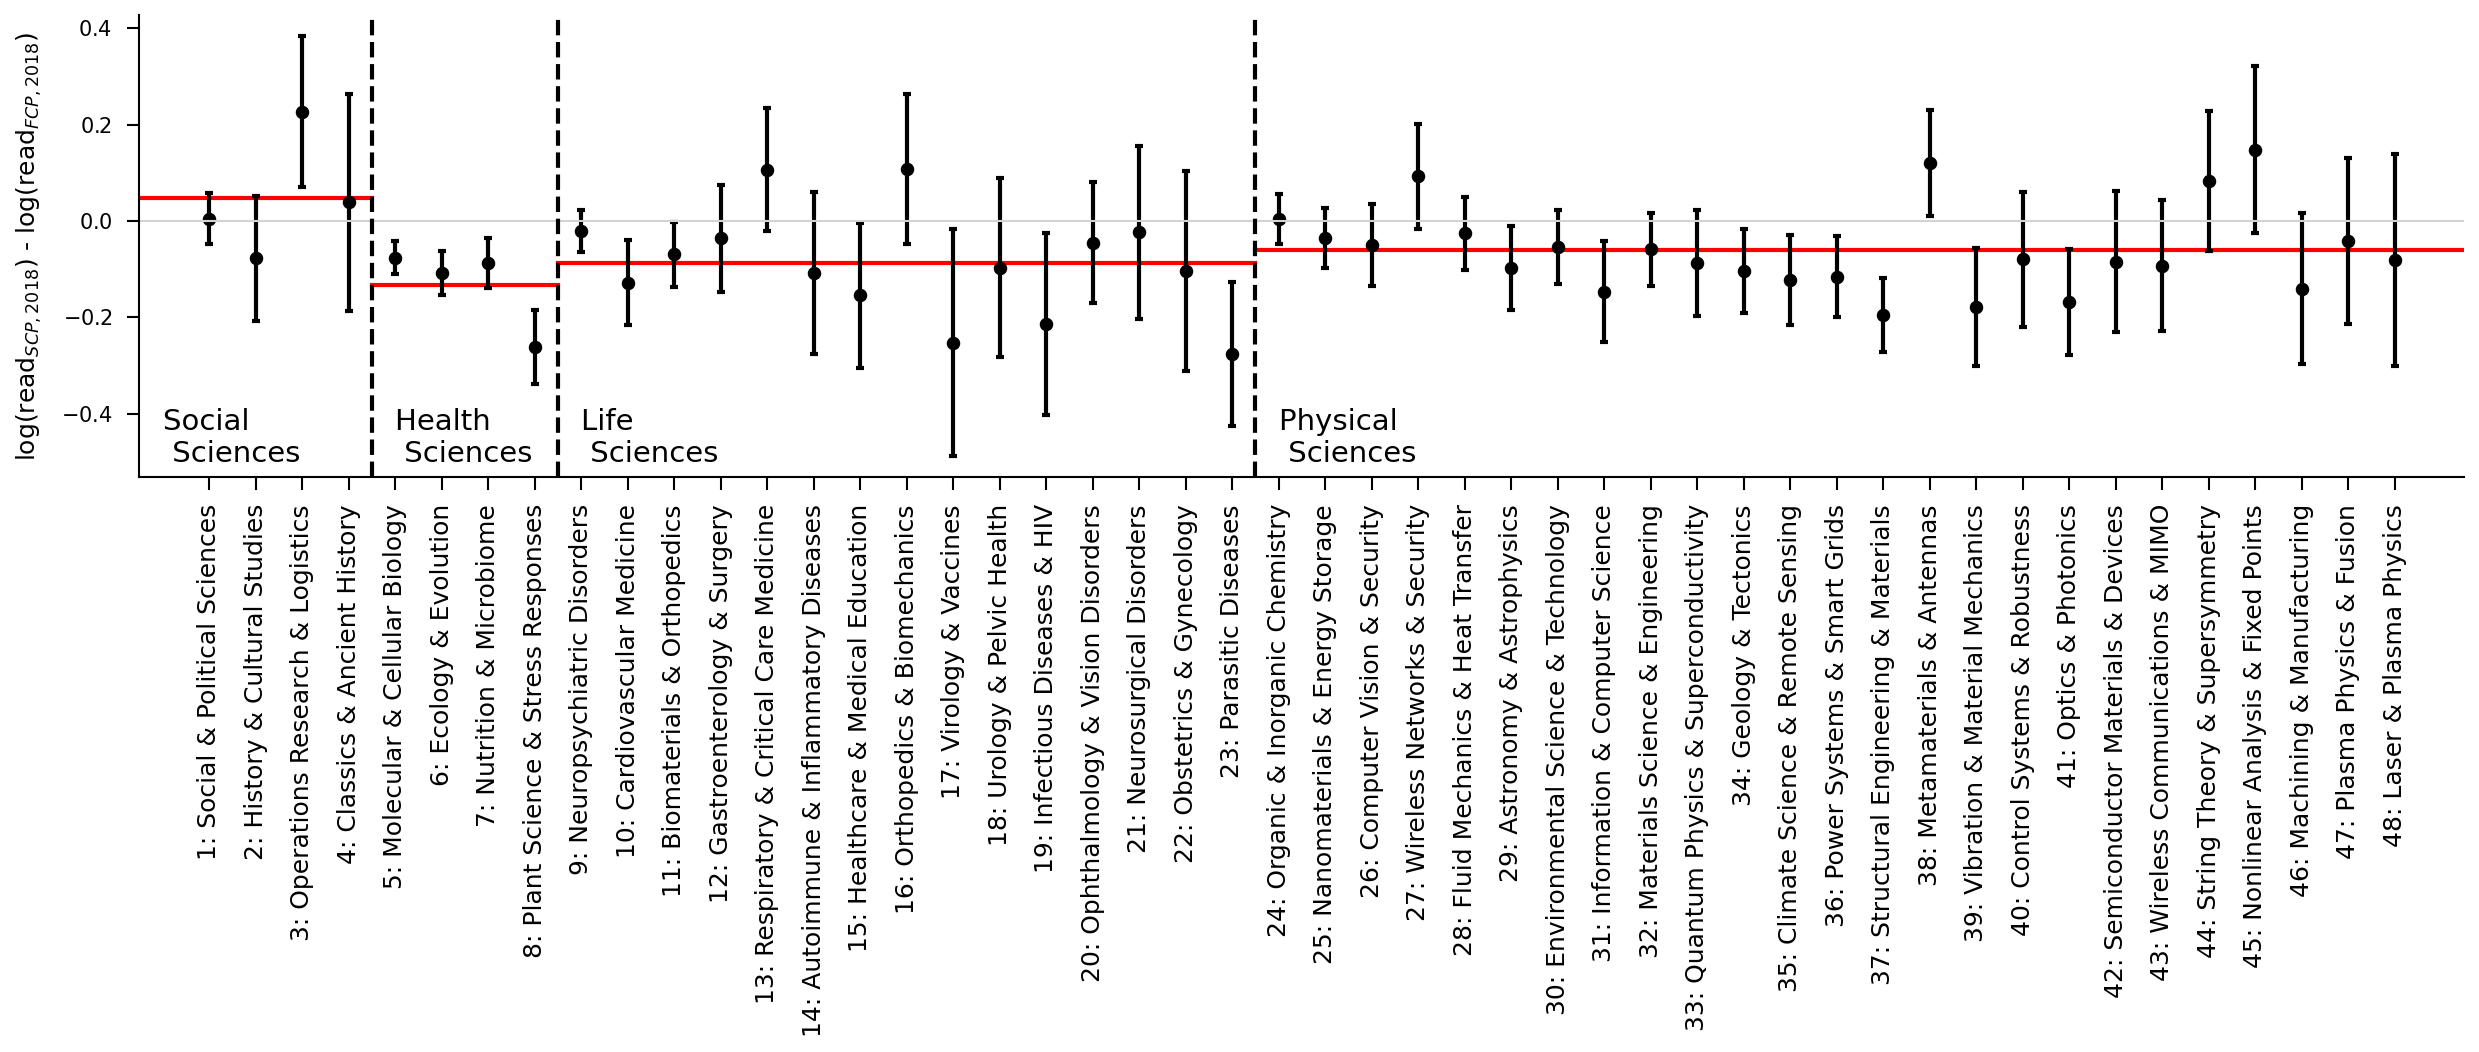

In [52]:
# 2018
y, y_err = [],[]

for partition in target_partitions:
    readers_slow_matched = papers_slow_fastmatched2021_journal.query(f'`partition_1e-06`=={partition}')['cumulative_reader_2018'].map(lambda x: np.log(x+1)).values
    readers_fast_matched = papers_fast_slowmatched2021_journal.query(f'`partition_1e-06`=={partition}')['cumulative_reader_2018'].map(lambda x: np.log(x+1)).values
    mean, err = calc_conf(readers_slow_matched - readers_fast_matched)
    y.append(mean) 
    y_err.append(err)

fig,ax = plt.subplots(figsize=(10,2))

x = range(MAX_PARTITION+1)
labels = [f'{j+1}: ' + keywords[i] for j,i in enumerate(target_partitions)]

print('全体平均', np.mean(y))
ax.scatter(x,y, s=5, color='black')
ax.errorbar(x, y, yerr=y_err, capsize=1, linestyle='None', color='black')

ax.axhline(0,c='lightgray',linestyle='-',linewidth=0.5)
ax.axhline(np.mean(y[:4]), xmin=0, xmax=0.1, linestyle='-', linewidth=1, color='red', zorder=-20) 
ax.axhline(np.mean(y[4:8]), xmin=0.1, xmax=0.18, linestyle='-', linewidth=1, color='red', zorder=-20) 
ax.axhline(np.mean(y[8:23]), xmin=0.18, xmax=0.48, linestyle='-', linewidth=1, color='red', zorder=-20) 
ax.axhline(np.mean(y[23:]), xmin=0.48, xmax=1, linestyle='-', linewidth=1, color='red', zorder=-20) 
print(np.mean(y[:4]))
print(np.mean(y[4:8]))
print(np.mean(y[8:23]))
print(np.mean(y[23:]))

ax.axvline(3.5, linestyle='--', linewidth=1, color='black') 
ax.axvline(7.5, linestyle='--', linewidth=1, color='black') 
ax.axvline(22.5, linestyle='--', linewidth=1, color='black') 

ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=90, fontsize=6)

ax.set_ylabel('log(read$_{SCP,2018}$) - log(read$_{FCP,2018}$)', fontsize=6)
ax.set_xlim(-1.5,48.5)

plt.text(-1,-0.5,'Social \n Sciences')
plt.text(4,-0.5,'Health \n Sciences')
plt.text(8,-0.5,'Life \n Sciences')
plt.text(23,-0.5,'Physical \n Sciences')

# ax.grid(axis='y', alpha=0.8)
# ax.legend(loc='upper right', fontsize=10)

plt.savefig('./scp_fcp_field_2018.eps')
plt.show()

全体平均 0.056143313611101316
0.15603365712525666
-0.005129131763022418
0.0629458802171973
0.04588290994503867


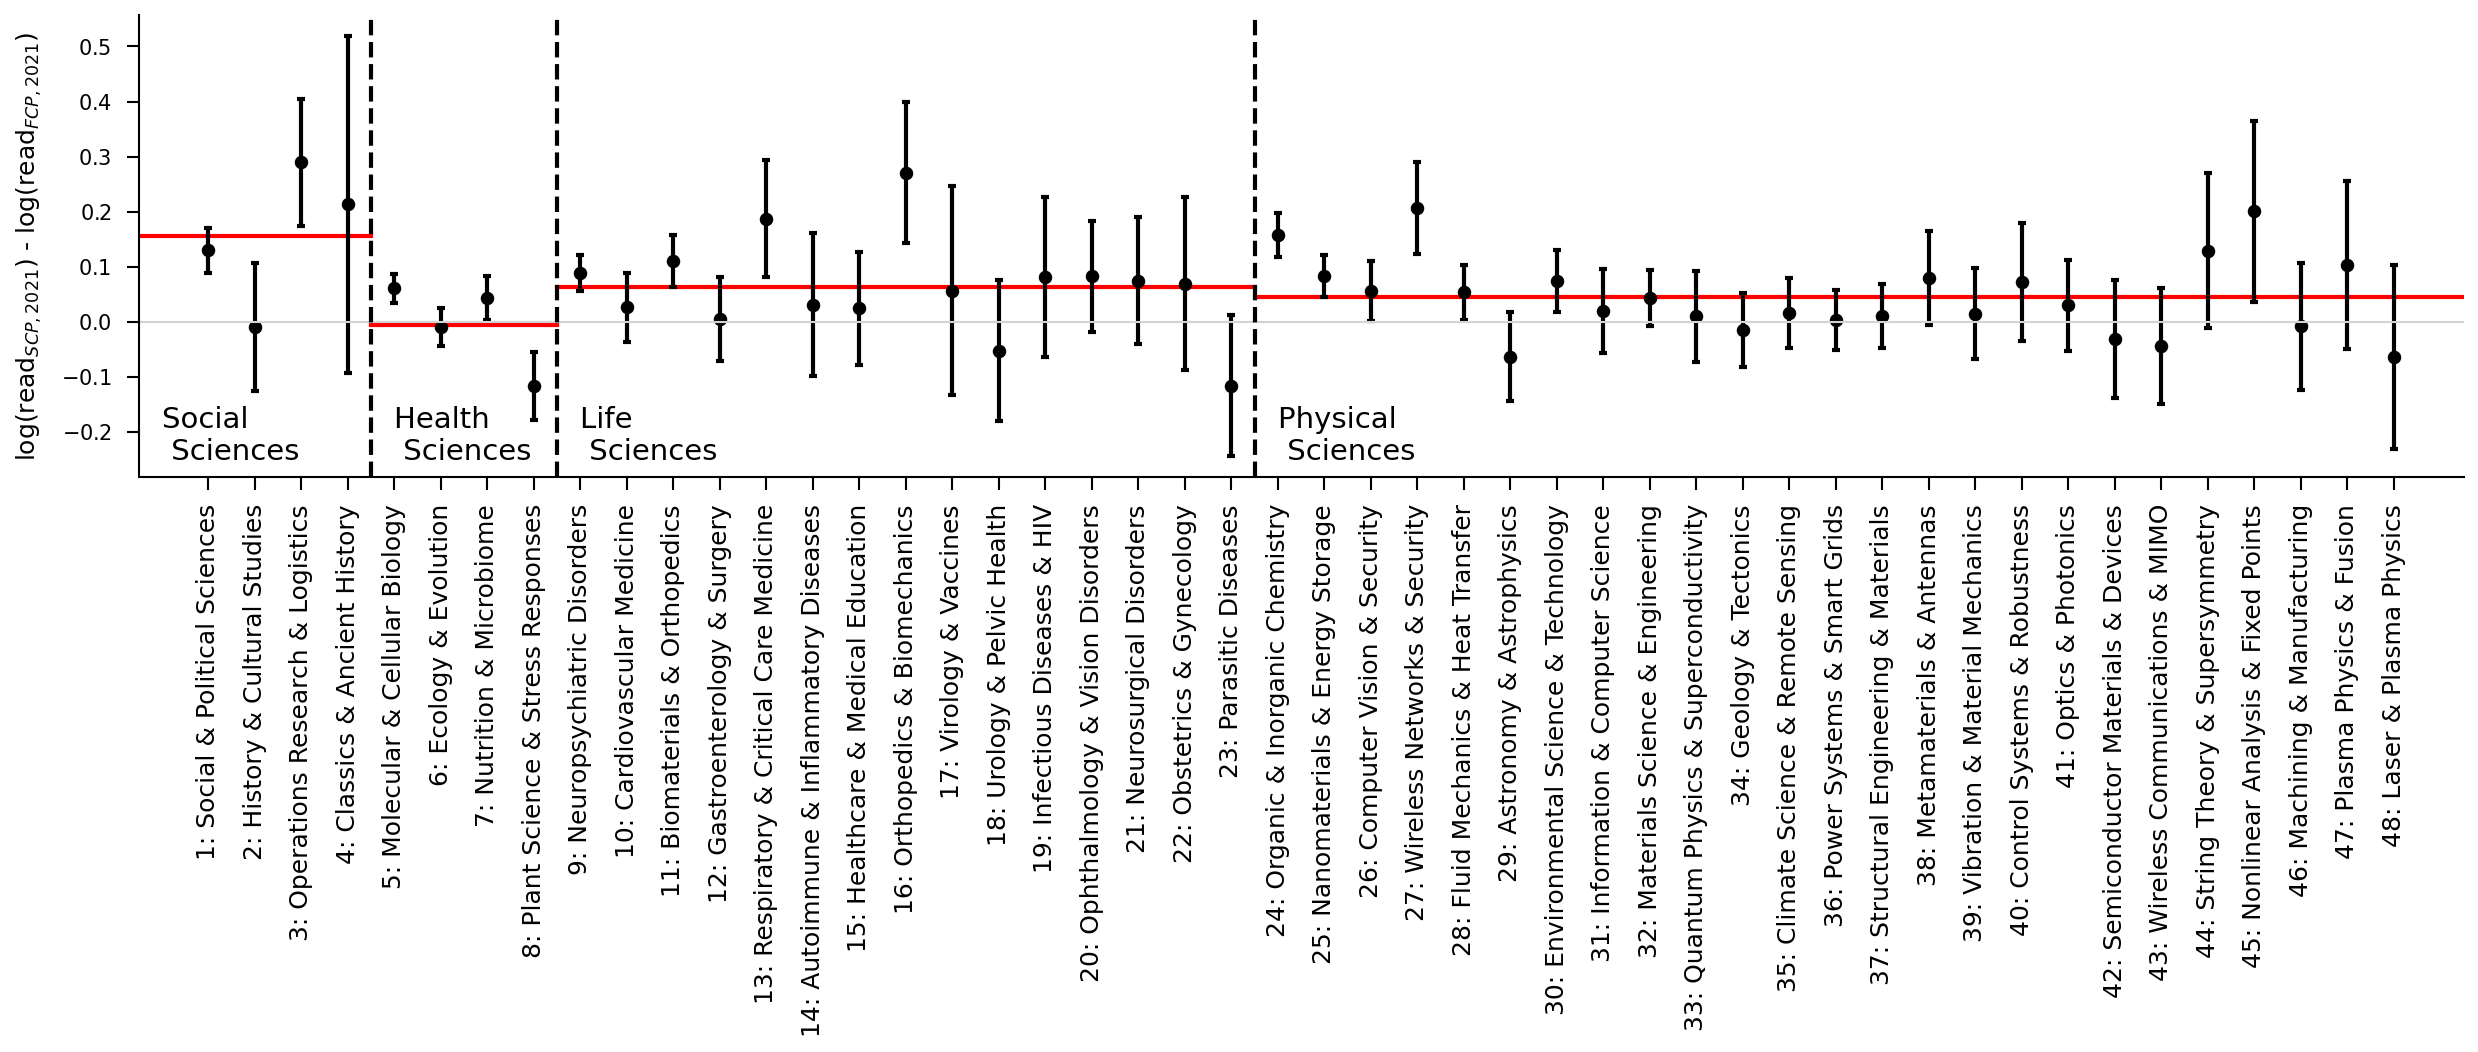

In [42]:
# 2021
y, y_err = [],[]

for partition in target_partitions:
    readers_slow_matched = papers_slow_fastmatched2021_journal.query(f'`partition_1e-06`=={partition}')['cumulative_reader_2021'].map(lambda x: np.log(x+1)).values
    readers_fast_matched = papers_fast_slowmatched2021_journal.query(f'`partition_1e-06`=={partition}')['cumulative_reader_2021'].map(lambda x: np.log(x+1)).values
    mean, err = calc_conf(readers_slow_matched - readers_fast_matched)
    y.append(mean) 
    y_err.append(err)

fig,ax = plt.subplots(figsize=(10,2))

x = range(MAX_PARTITION+1)
labels = [f'{j+1}: ' + keywords[i] for j,i in enumerate(target_partitions)]

print('全体平均', np.mean(y))
ax.scatter(x,y, s=5, color='black')
ax.errorbar(x, y, yerr=y_err, capsize=1, linestyle='None', color='black')

ax.axhline(0,c='lightgray',linestyle='-',linewidth=0.5)
ax.axhline(np.mean(y[:4]), xmin=0, xmax=0.1, linestyle='-', linewidth=1, color='red', zorder=-20) 
ax.axhline(np.mean(y[4:8]), xmin=0.1, xmax=0.18, linestyle='-', linewidth=1, color='red', zorder=-20) 
ax.axhline(np.mean(y[8:23]), xmin=0.18, xmax=0.48, linestyle='-', linewidth=1, color='red', zorder=-20) 
ax.axhline(np.mean(y[23:]), xmin=0.48, xmax=1, linestyle='-', linewidth=1, color='red', zorder=-20) 
print(np.mean(y[:4]))
print(np.mean(y[4:8]))
print(np.mean(y[8:23]))
print(np.mean(y[23:]))

ax.axvline(3.5, linestyle='--', linewidth=1, color='black') 
ax.axvline(7.5, linestyle='--', linewidth=1, color='black') 
ax.axvline(22.5, linestyle='--', linewidth=1, color='black') 

ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=90, fontsize=6)

ax.set_ylabel('log(read$_{SCP,2021}$) - log(read$_{FCP,2021}$)', fontsize=6)
ax.set_xlim(-1.5,48.5)

plt.text(-1,-0.25,'Social \n Sciences')
plt.text(4,-0.25,'Health \n Sciences')
plt.text(8,-0.25,'Life \n Sciences')
plt.text(23,-0.25,'Physical \n Sciences')

# ax.grid(axis='y', alpha=0.8)
# ax.legend(loc='upper right', fontsize=10)

plt.savefig('./scp_fcp_field_2021.eps')
plt.show()

## 3.2 doctype

In [266]:
y, y_err = [],[]

papers_havedoctypes = pd.merge(
    papers_slow_fastmatched2021_journal.assign(id=range(len(papers_slow_fastmatched2021_journal))), 
    papers_fast_slowmatched2021_journal.assign(id=range(len(papers_fast_slowmatched2021_journal))), 
    on='id',
    suffixes=('_slow','_fast'),
).dropna(subset=['doctype_slow','doctype_fast']).query('doctype_slow == doctype_fast')
for doctype in ['ar','cp','re']:
    readers_slow_matched = papers_havedoctypes.query(f'doctype_slow=="{doctype}"')['cumulative_reader_2018_slow'].map(lambda x: np.log(x+1)).values
    readers_fast_matched = papers_havedoctypes.query(f'doctype_fast=="{doctype}"')['cumulative_reader_2018_fast'].map(lambda x: np.log(x+1)).values
    print(doctype, len(readers_slow_matched))
    mean, err = calc_conf(readers_slow_matched - readers_fast_matched)
    y.append(mean) 
    y_err.append(err)

ar 17299
cp 739
re 522


In [108]:
papers_havedoctypes.shape

(18569, 79)

In [109]:
y, np.exp(y)

([-0.06067284990350978, 0.0519078783364693, -0.06573819581741606],
 array([0.94113108, 1.05327871, 0.93637598]))

全体平均 -0.02483438912815218


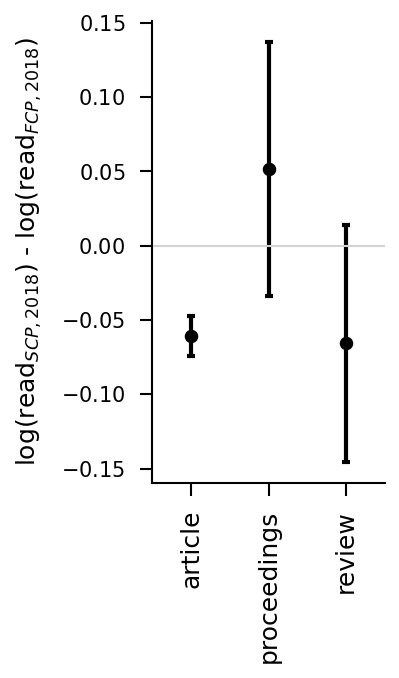

In [111]:
fig,ax = plt.subplots(figsize=(1,2))

x = range(3)
labels = ['article', 'proceedings', 'review']

print('全体平均', np.mean(y))
ax.scatter(x,y, s=5, color='black')
ax.errorbar(x, y, yerr=y_err, capsize=1, linestyle='None', color='black')

ax.axhline(0,c='lightgray',linestyle='-',linewidth=0.5)

ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=90, fontsize=6)

ax.set_ylabel('log(read$_{SCP,2018}$) - log(read$_{FCP,2018}$)', fontsize=6)

ax.set_xlim(-0.5,2.5)
# ax.set_ylim(-0.05, ax.get_ylim()[1])

# ax.grid(axis='y', alpha=0.8)
# ax.legend(loc='upper right', fontsize=10)

plt.savefig('../doc/figs_update_11/scp_fcp_doctype.eps')
plt.show()